## Continuous Pre-training using LLM recipie

In [1]:
! pip install datasets transformers torch tensorboard

  Using cached triton-3.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.4 kB)
Using cached triton-3.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (253.1 MB)
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0


In [15]:
# ====================================================IMPORT=================================================================

from datasets import DatasetDict, load_dataset, load_from_disk, Dataset

import os
import warnings
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
import time
from torch.utils.tensorboard import SummaryWriter

warnings.filterwarnings("ignore")


from datasets import load_from_disk
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)
import torch
import pandas as pd
import sys
import os
from datasets import Dataset
import argparse
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM

# ========================== CMD Argument Parser ==========================
# def parse_args():
#     parser = argparse.ArgumentParser(description="Train a model using CPT (Continual Pretraining Training)")
#     parser.add_argument("--per_device_train_batch_size", type=int, default=10, help="Batch size per device during training")
#     parser.add_argument("--per_device_eval_batch_size", type=int, default=10, help="Batch size per device during evaluation")
#     parser.add_argument("--src_lng", type=str, default="English", help="Source language default English")
#     parser.add_argument("--tgt_lng", type=str, default="Luxembourgish", help="Target language default Luxembourgish")
#     parser.add_argument("--num_train_epochs", type=int, default=5, help="Number of training epochs")
#     parser.add_argument("--learning_rate", type=float, default=1e-6, help="Learning rate for training")
#     parser.add_argument("--project_root", type=str, default="/Users/lujun.li/projects/mt_luxembourgish", help="Path to project root")
#     parser.add_argument("--training_dataset_path", type=str, default="data/processed/dataset_merged_llama_fake_targets.jsonl", help="Path to training dataset")
#     parser.add_argument("--model_name", type=str, default="/home/llama/Personal_Directories/srb/binary_classfication/Llama-3.2-3B-Instruct", help="Path to model")
#     parser.add_argument("--resume_from_checkpoint", type=bool, default=False, help="Resume training from checkpoint")
#     parser.add_argument("--resume_checkpoint_path", type=str, default=None, help="Path to checkpoint to resume training from")
#     return parser.parse_args()

# args = parse_args()

# print("Arguments passed:")
# print(f"Train Batch Size: {args.per_device_train_batch_size}")
# print(f"Eval Batch Size: {args.per_device_eval_batch_size}")
# print(f"Number of Epochs: {args.num_train_epochs}")
# print(f"Learning Rate: {args.learning_rate}")
# print(f"Project Root: {args.project_root}")
# print(f"Training Dataset Path: {args.training_dataset_path}")
# print(f"Model Name: {args.model_name}")
# print(f"tgt_lng: {args.tgt_lng}")
# print(f"src_lng: {args.src_lng}")
# print(f"Resume from checkpoint: {args.resume_from_checkpoint}")
# print(f"Resume checkpoint path: {args.resume_checkpoint_path}")

# learning_rate = args.learning_rate # Learning rate for the optimizer
# per_device_train_batch_size = args.per_device_train_batch_size  # Batch size for training per device
# per_device_eval_batch_size = args.per_device_eval_batch_size  # Batch size for evaluation per device
# num_train_epochs = args.num_train_epochs  # Number of epochs for training
# training_dataset_path = args.training_dataset_path
# project_root = args.project_root
# model_name = args.model_name
# resume_from_checkpoint = args.resume_from_checkpoint
# resume_checkpoint_path = args.resume_checkpoint_path
# src_lng = args.src_lng
# tgt_lng = args.tgt_lng


learning_rate = 1e-6 # Learning rate for the optimizer
per_device_train_batch_size = 1  # Batch size for training per device
per_device_eval_batch_size = 1  # Batch size for evaluation per device
num_train_epochs = 3  # Number of epochs for training
training_dataset_path = "data/training_dataset/dataset_GPT_split.jsonl"
project_root = "/home/snt/projects_lujun/mt_luxembourgish"
model_name = "/home/snt/llm_models/Llama-3.2-1B-Instruct"
src_lng = "English"
tgt_lng = "Luxembourgish"
resume_from_checkpoint = False
resume_checkpoint_path = None

train_ratio = 0.01  # Number of samples to be used for training and evaluation
warmup_ratio = 0.5
logging_steps = 300
evaluation_strategy="steps"
save_strategy="epoch"
eval_steps=300
max_grad_norm = 0.3
fp16 = True
MAX_LEN = 512
weight_decay = 0.01

if resume_from_checkpoint and resume_checkpoint_path is None:
    raise ValueError("Please provide a checkpoint path to resume training from")

val_dataset_path = os.path.abspath(os.path.join(project_root, "data/fake_targets/flores_devtest_arrow"))
train_dataset_path = os.path.abspath(os.path.join(project_root, "data/training_dataset/dataset_GPT_split.jsonl"))
sys.path.append(project_root)

Map: 100%|██████████| 36/36 [00:00<00:00, 3166.11 examples/s]


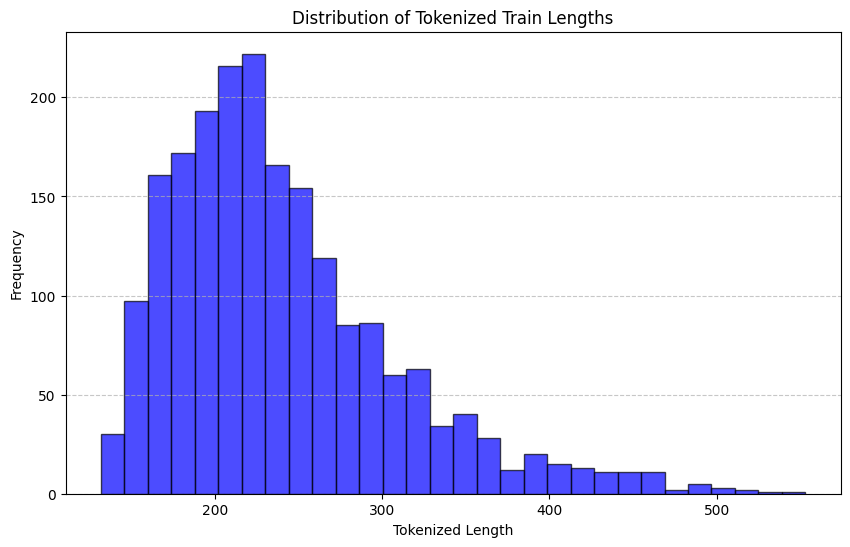

In [16]:
# ========================== Main Training Code ==========================


val_dataset_path = os.path.abspath(os.path.join(project_root, "data/fake_targets/flores_devtest_arrow"))
train_dataset_path = os.path.abspath(os.path.join(project_root, training_dataset_path))
sys.path.append(project_root)

# Load dataset
if train_dataset_path.endswith(".jsonl"):
    dataset = Dataset.from_json(train_dataset_path)  # Ensure correct format
else:
    dataset = load_from_disk(train_dataset_path)

# Filter by split
train_dataset = dataset.filter(lambda x: x["split"] == "train")
val_dataset = dataset.filter(lambda x: x["split"] == "val")


# Select subset
train_dataset = train_dataset.select(range(int(len(train_dataset) * train_ratio)))
val_dataset = val_dataset.select(range(int(len(val_dataset) * train_ratio)))  # Avoid out-of-range error

# Rename columns
train_dataset = train_dataset.rename_columns({
    "input": "Luxembourgish",
    "translated_text": "English",
})

val_dataset = val_dataset.rename_columns({
    "input": "Luxembourgish",
    "translated_text": "English",
})


tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token


# def create_prompt(
#     sample, src_lng, tgt_lng, mode="train", tokenizer=None
# ):
    # if tokenizer is None or tokenizer.eos_token is None:
    #     raise ValueError("A tokenizer with a defined EOS token is required.")

    # system_message = f"You are a helpful AI assistant for translation."
    # input_text = sample[src_lng.capitalize()].strip()  # Extract the input text.
    # response = ( sample[tgt_lng.capitalize()].strip() if tgt_lng.capitalize() in sample else "")  # Extract the target text.

    # # Get the EOS token from the tokenizer.
    # eos_token = tokenizer.eos_token

#     # Construct the full prompt.
#     full_prompt = (
#         "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n" + system_message + "<|eot_id|>" +  # System Message
        # "<|start_header_id|>user<|end_header_id|>\n\n" + f"Translate the English input text into Luxembourgish. Do not include any additional information or unrelated content.\n\n{input_text}"  +  "<|eot_id|><|start_header_id|>assistant<|end_header_id|>" # User Query
    # )

#     if mode == "train":
#         full_prompt += ("\n\n" + response + eos_token)

#     return {"full_prompt": full_prompt}

def create_prompt(sample, src_lng, tgt_lng, mode="train", tokenizer=None):

    if tokenizer is None or tokenizer.eos_token is None:
        raise ValueError("A tokenizer with a defined EOS token is required.")

    system_message = f"You are a helpful AI assistant for translation."
    input_text = sample[src_lng.capitalize()].strip()  # Extract the input text.
    response = ( sample[tgt_lng.capitalize()].strip() if tgt_lng.capitalize() in sample else "")  # Extract the target text.
    question = f"Translate the following English input text into Luxembourgish. Do not include any additional information or unrelated content.\n\n{input_text}"
    # Get the EOS token from the tokenizer.
    eos_token = tokenizer.eos_token
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": question},
        {"role": "assistant", "content": response}
    ]
    
    full_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
    return { "full_prompt": full_prompt }

train_dataset = train_dataset.map(
    lambda sample: {
        "full_prompt": create_prompt(sample, src_lng=src_lng, tgt_lng=tgt_lng, mode="train", tokenizer=tokenizer)["full_prompt"]
    }
).select_columns(["full_prompt"])

val_dataset = val_dataset.map(
    lambda sample: {
        "full_prompt": create_prompt(sample, src_lng=src_lng, tgt_lng=tgt_lng, mode="train", tokenizer=tokenizer)["full_prompt"]
    }
).select_columns(["full_prompt"])


# data_collator = DataCollatorForLanguageModeling(
#     tokenizer, mlm=False, return_tensors="pt"
# )

def compute_lengths(dataset, tokenizer):
    lengths = [len(tokenizer(sample["full_prompt"])["input_ids"]) for sample in dataset]
    return lengths

import matplotlib.pyplot as plt

train_lengths = compute_lengths(train_dataset, tokenizer)
val_lengths = compute_lengths(val_dataset, tokenizer)

plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Tokenized Length")
plt.ylabel("Frequency")
plt.title("Distribution of Tokenized Train Lengths")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [17]:

def tokenize_function(examples):
    return tokenizer(
        examples["full_prompt"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors="pt",
    )


tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["full_prompt"])
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=["full_prompt"])


instruction_template = "<|start_header_id|>user<|end_header_id|>\n\n"
response_template = "<|start_header_id|>assistant<|end_header_id|>\n\n"

data_collator = DataCollatorForCompletionOnlyLM(
    instruction_template=instruction_template,
    response_template=response_template,
    tokenizer=tokenizer,
    mlm=False
)



Map: 100%|██████████| 36/36 [00:00<00:00, 2130.65 examples/s]


In [18]:
print("Example Prompt:    "+"*"*50)
print (train_dataset["full_prompt"][0])
print("Example Prompt:    "+"*"*50)

Example Prompt:    **************************************************
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 28 Feb 2025

You are a helpful AI assistant for translation.<|eot_id|><|start_header_id|>user<|end_header_id|>

Translate the following English input text into Luxembourgish. Do not include any additional information or unrelated content.

In both the women's and men's events, the mass start was on the program as part of the Tour de Ski in Switzerland. The women were challenged on a 10-kilometer circuit, and it was Linn Svahn from Sweden who managed to secure victory in the final sprint. In second place was Russia's Julia Stupak, ahead of the American Jessie Diggins.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Bei den Dammen a bei den Häre stoung an der Schwäiz de Massestart am Kader vum Tour de Ski um Programm. D'Damme waren op engem Circuit iwwer 10 Kilometer gefuerdert a sou war et d'Linn Svah

In [19]:
from accelerate import Accelerator

# ====================================================TRAINING=================================================================
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    return f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"

def train_ddp_accelerate_sft():
    accelerator = Accelerator()
    
    model = AutoModelForCausalLM.from_pretrained(model_name)
    model.config.use_cache = False
    model = accelerator.prepare(model)
    current = time.time()
    formatted_time = time.strftime("%m_%d_%H_%M", time.localtime(current))
    if resume_from_checkpoint:
        output_dir = resume_checkpoint_path
    else:
        input_file_name = training_dataset_path.split("/")[-1].split(".")[0]
        output_dir = f"logs/{src_lng[:2]}_{tgt_lng[:2]}/fit_{formatted_time}_{train_ratio}_{input_file_name}"

    print(print_trainable_parameters(model))
    
    training_args = SFTConfig(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        warmup_ratio=warmup_ratio,
        evaluation_strategy=evaluation_strategy,
        save_strategy=save_strategy,
        logging_steps=logging_steps,
        eval_steps=eval_steps,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        fp16=fp16,
        max_grad_norm=max_grad_norm,
        group_by_length=True,
        lr_scheduler_type="cosine",
        report_to="tensorboard",
        ddp_find_unused_parameters=False,
        remove_unused_columns=False,
        disable_tqdm=False,
        # load_best_model_at_end=True,
    )

    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train(resume_from_checkpoint=resume_from_checkpoint)
    print("Finished training SFT.")


In [20]:
def main():
    train_ddp_accelerate_sft()

if __name__ == "__main__":
    main()

trainable params: 1235814400 || all params: 1235814400 || trainable%: 100.0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss
300,3.817900,3.554043
600,3.079700,2.979929


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


KeyboardInterrupt: 

In [17]:
import time
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments, pipeline
import torch


device = "cuda:0"
model_checkpoint = "/home/snt/projects_lujun/mt_luxembourgish/logs/En_Lu/fit_02_26_02_15_0.001_dataset_GPT_split/checkpoint-609"
model = AutoModelForCausalLM.from_pretrained(model_checkpoint).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
system_message = f"You are a helpful AI assistant for translation."
input_text = """The concept of the lead candidate is not without controversy: One pro-argument is that the election becomes more democratic this way. On the other hand, the heads of state and government lose power as a result. Simply put, the EU is responsible for what is agreed upon between it and the member states, for example, for the internal market, trade policy, monetary policy, and competition rules, and there is also a common security and foreign policy."""
eos_token = tokenizer.eos_token

# Construct the full prompt.
full_prompt = (
    "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n" + system_message + "<|eot_id|>" +  # System Message
    "<|start_header_id|>user<|end_header_id|>\n\n" + f"Translate the English input text into Luxembourgish. Do not include any additional information or unrelated content.\n\n{input_text}"  +  "<|eot_id|><|start_header_id|>assistant<|end_header_id|>" # User Query
)

# full_prompt = f"Translate the English input text into Luxembourgish.\n{input_text}. Do not include any additional information or unrelated content."

# Tokenize input text
encoded_input = tokenizer(full_prompt, return_tensors="pt", add_special_tokens=True)
model_inputs = encoded_input.to(device)
generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=512,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id,
        temperature=1.0,
    )
decoded_output = tokenizer.batch_decode(generated_ids)[0].replace(full_prompt, "")

special_tokens = tokenizer.all_special_tokens
for token in special_tokens:
    decoded_output = decoded_output.replace(token, "")
    
print("Test Output:\n", decoded_output)


Test Output:
 

De Konzept vum éissten Zweeten Kandidaten ass net ohne Kämpft op de Leschter: E Pro Argument géif d’Wahl mä méi démokrateesch déi Weidergehalten. An deem Zuel géif den Éischte Exekutiv-Residenten an den Regierungsresidenten op d’Spill gréisst. Esou geet einfach, déi EU géif déi fir deenen am Vertrag mat de Membrancer ënnerkleeften ëm Beilechen. Zum Beispill fëren d'Mënschent, d'Traderpolt, d'Monetairpolt, d'Konkurrenzvirschrëfte an d'Zerwéierung vun der EU.


In [19]:
print (full_prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful AI assistant for translation.<|eot_id|><|start_header_id|>user<|end_header_id|>

Translate the English input text into Luxembourgish. Do not include any additional information or unrelated content.

The concept of the lead candidate is not without controversy: One pro-argument is that the election becomes more democratic this way. On the other hand, the heads of state and government lose power as a result. Simply put, the EU is responsible for what is agreed upon between it and the member states, for example, for the internal market, trade policy, monetary policy, and competition rules, and there is also a common security and foreign policy.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
